# out_fiberID
* 기존변수 + u-g,g-r,r-i,i-z만 추가변수로 사용
* fiber_ID를 제외하고 진행해봄
* 제출결과 : 0.4076887978
-> oversample자체가 다소 overfitting되는듯

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss


import lightgbm as lgb
from sklearn.model_selection import KFold

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [6]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

### outlier

In [7]:
def del_outlier(data, min=0, max=60):
    up_idx_t=()
    dw_idx_t=()
    train_light = data.iloc[:,2:]
    for i in range(len(train_light.columns)):
        col = train_light.columns[i]
        up_idx_t+=tuple(data[data[col]>max].index)
        dw_idx_t+=tuple(data[data[col]<min].index)
    del_idx = set(up_idx_t+dw_idx_t)
    
    return data[~data.index.isin(del_idx)]

In [8]:
train_df = del_outlier(train_df, min=-60, max=60)

### oversampling

In [9]:
# 전부를 오버샘플링하지 않고 하위 5개만 오버샘플림을 징행한다
last5 = train_df.type.value_counts().tail().index
last5_df = train_df[train_df.type.apply(lambda x : x in last5)]
not_last5_df = train_df[train_df.type.apply(lambda x : x not in last5)]
not_last5_df.shape

(197951, 22)

In [10]:
last5_df.type.value_counts()

STAR_SUB_DWARF        1154
STAR_BROWN_DWARF       500
SKY                    126
SERENDIPITY_MANUAL      61
STAR_PN                 13
Name: type, dtype: int64

In [11]:
last5_df.head()

,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
id,,,,,,,,,,,,,,,,,,,,,,
130,STAR_BROWN_DWARF,307,24.000698,24.130331,22.397570,19.683266,17.899966,22.140558,23.953209,22.395944,20.004330,18.254870,23.335455,23.888990,22.326547,19.869744,17.979923,23.455427,24.435867,21.982169,19.627870,17.862923
178,STAR_SUB_DWARF,473,22.513232,20.303728,18.669804,17.335240,16.620192,22.980001,20.680711,18.988550,17.660633,16.957475,22.713534,20.378224,18.760992,17.400832,16.655114,23.064942,20.272060,18.684383,17.331097,16.615294
233,STAR_SUB_DWARF,18,25.281941,21.123560,19.451201,18.191930,17.539610,25.319303,21.542624,19.770037,18.532062,17.800853,25.219737,21.223090,19.524615,18.261213,17.567673,24.509561,21.291082,19.455164,18.196549,17.504771
374,STAR_BROWN_DWARF,454,24.500492,25.904337,23.313455,20.724750,18.827761,24.477704,24.866447,24.107851,21.187014,19.167432,23.176587,25.175837,24.938311,20.913233,18.823344,25.447687,25.691341,23.336237,20.731457,18.868444
693,SKY,296,23.037785,24.284405,23.731336,23.368552,21.608077,22.862479,25.740279,24.637647,23.034074,22.069032,23.458058,27.641061,25.728314,24.174830,23.510288,22.021153,25.627174,24.336437,23.670336,21.695816


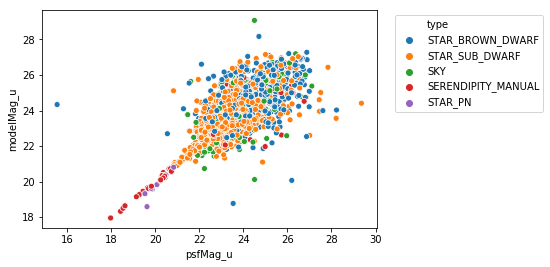

In [12]:
#범위축소해서 비교
s_train_df = last5_df[(last5_df.psfMag_u>10)&(last5_df.psfMag_u<30)]
s_train_df = s_train_df[(s_train_df.psfMag_g>10)&(s_train_df.psfMag_g<30)]

sns.scatterplot(x= 'psfMag_u', y= 'modelMag_u', hue = 'type', data = s_train_df)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [13]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

y = last5_df.type
X = last5_df.drop('type',axis = 1)

X.shape

Using TensorFlow backend.
C:\Users\starl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\starl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\starl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\starl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

(1854, 21)

In [14]:
resample_X, resample_y = sm.fit_resample(X,y)

In [15]:
resample_X.shape

(5770, 21)

In [16]:
new_train_last5 = pd.concat([resample_X,resample_y],axis = 1)
new_train_last5 = new_train_last5[train_df.columns]

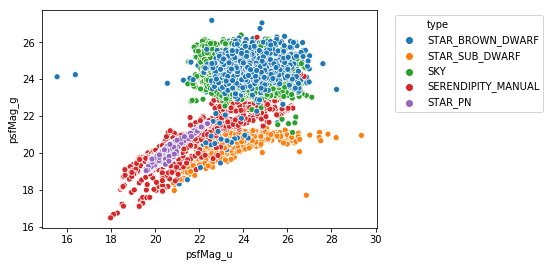

In [17]:
#범위축소해서 비교
s_train_df = new_train_last5[(new_train_last5.psfMag_u>10)&(new_train_last5.psfMag_u<30)]
s_train_df = s_train_df[(s_train_df.psfMag_g>10)&(s_train_df.psfMag_g<30)]

sns.scatterplot(x= 'psfMag_u', y= 'psfMag_g', hue = 'type', data = s_train_df)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [18]:
#concat oversample + 기존
new_train = pd.concat([not_last5_df,new_train_last5])
new_train.shape

(203721, 22)

## DATA Setting

In [19]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

new_train['type_num'] = new_train['type'].apply(lambda x: to_number(x, column_number))


In [20]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [21]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [22]:
train_df = add_minus_feature_all(new_train)
test_df = add_minus_feature_all(test_df,True)

In [23]:
train_df.shape,test_df.shape

((203721, 63), (10009, 61))

In [24]:
train_df.columns

Index(['type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'type_num', 'psfMag_u-g', 'psfMag_u-r', 'psfMag_u-i',
       'psfMag_u-z', 'psfMag_g-r', 'psfMag_g-i', 'psfMag_g-z', 'psfMag_r-i',
       'psfMag_r-z', 'psfMag_i-z', 'fiberMag_u-g', 'fiberMag_u-r',
       'fiberMag_u-i', 'fiberMag_u-z', 'fiberMag_g-r', 'fiberMag_g-i',
       'fiberMag_g-z', 'fiberMag_r-i', 'fiberMag_r-z', 'fiberMag_i-z',
       'petroMag_u-g', 'petroMag_u-r', 'petroMag_u-i', 'petroMag_u-z',
       'petroMag_g-r', 'petroMag_g-i', 'petroMag_g-z', 'petroMag_r-i',
       'petroMag_r-z', 'petroMag_i-z', 'modelMag_u-g', 'modelMag_u-r',
       'modelMag_u-i', 'modelMag_u-z', 'modelMag_g-r', 'modelMag_g-i',
       'modelMag_g-z', 'modelMag_r-i', 'modelMag_r-z

In [25]:
train_X = train_df.drop(columns=['type', 'type_num','fiberID'], axis=1)
train_y = train_df['type_num']
test_X = test_df.drop(columns = ['fiberID'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [27]:
train_ds = lgb.Dataset(X_train, label = y_train)
test_ds = lgb.Dataset(X_test, label = y_test) 

In [28]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': train_y.nunique(),
    'metric': {'multi_logloss','multi_logloss'},
    'num_leaves': 25,
    'learning_rate': 0.05,
    'max_depth' : 12,
    'random_state' : 42
}

## Modeling

In [29]:
evaluation_results = {}
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, 
                       valid_sets = [train_ds,test_ds], valid_names=['Train', 'Test'],
                       evals_result=evaluation_results,
                       verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	Train's multi_logloss: 0.346598	Test's multi_logloss: 0.404945
[200]	Train's multi_logloss: 0.2803	Test's multi_logloss: 0.372847
[300]	Train's multi_logloss: 0.247673	Test's multi_logloss: 0.368054
[400]	Train's multi_logloss: 0.222093	Test's multi_logloss: 0.367294
[500]	Train's multi_logloss: 0.201516	Test's multi_logloss: 0.367967
Early stopping, best iteration is:
[408]	Train's multi_logloss: 0.220255	Test's multi_logloss: 0.367247


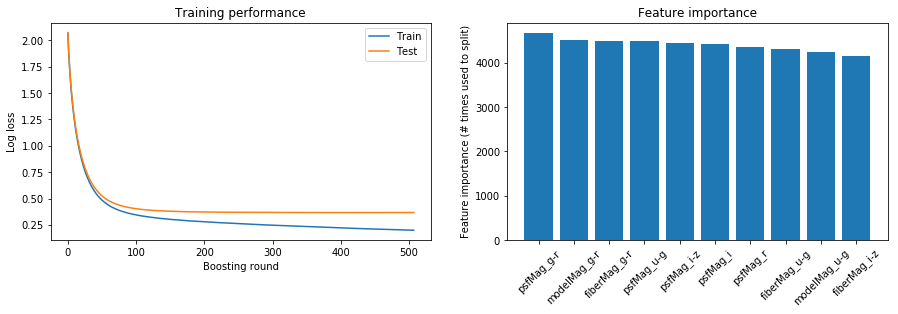

In [30]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['multi_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['multi_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': lgmb_model.feature_name(), 
                            'importance': lgmb_model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'])
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')
plt.xticks(rotation=45)

plt.show()

In [31]:
train_y_pred = lgmb_model.predict(X_test)
real_y_pred = lgmb_model.predict(test_X)

In [32]:
train_y_pred.shape

(61117, 19)

In [33]:
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.3672470908046061

In [34]:
lgmb_model.feature_importance()

array([2959, 3808, 4353, 4434, 3114, 2983, 3231, 2760, 3974, 2819, 3507,
       2277, 2760, 3071, 2765, 3112, 2569, 2548, 2364, 3541, 4483, 3050,
       2094, 1743, 4672, 2335, 2093, 3888, 2825, 4440, 4304, 3036, 1919,
       2380, 4498, 2580, 1972, 3994, 3152, 4147, 3760, 2629, 2032, 2310,
       3787, 2349, 2255, 3550, 2449, 3900, 4245, 2703, 1854, 1874, 4519,
       2258, 2064, 3855, 3139, 3962])

### feature_importance

In [35]:
pi_df = pd.DataFrame(lgmb_model.feature_importance(), index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df.head(10)

,importance
psfMag_g-r,4672
modelMag_g-r,4519
fiberMag_g-r,4498
psfMag_u-g,4483
psfMag_i-z,4440
psfMag_i,4434
psfMag_r,4353
fiberMag_u-g,4304
modelMag_u-g,4245
fiberMag_i-z,4147


### 예측결과에 대해
* 12번이 모두 6번으로 몰림
중간예측 : 0(STAR_WHITE_DWARF-2160),2(STAR_BROWN_DWARF-500),7(SERENDIPITY_DISTANT-4654),11(ROSAT_D-6580)
망한예측 : 12(STAR_PN-13),17(SERENDIPITY_MANUAL-61)

In [36]:
cm_result = pd.DataFrame(confusion_matrix(y_test,np.argmax(train_y_pred,axis = 1)))

In [37]:
number_columns

{0: 'STAR_WHITE_DWARF',
 1: 'STAR_CATY_VAR',
 2: 'STAR_BROWN_DWARF',
 3: 'SERENDIPITY_RED',
 4: 'REDDEN_STD',
 5: 'STAR_BHB',
 6: 'GALAXY',
 7: 'SERENDIPITY_DISTANT',
 8: 'QSO',
 9: 'SKY',
 10: 'STAR_RED_DWARF',
 11: 'ROSAT_D',
 12: 'STAR_PN',
 13: 'SERENDIPITY_FIRST',
 14: 'STAR_CARBON',
 15: 'SPECTROPHOTO_STD',
 16: 'STAR_SUB_DWARF',
 17: 'SERENDIPITY_MANUAL',
 18: 'SERENDIPITY_BLUE'}

In [38]:
train_df.type.value_counts()

QSO                    49643
GALAXY                 37281
SERENDIPITY_BLUE       21753
SPECTROPHOTO_STD       14629
REDDEN_STD             14615
STAR_RED_DWARF         13748
STAR_BHB               13493
SERENDIPITY_FIRST       7126
ROSAT_D                 6532
STAR_CATY_VAR           6505
SERENDIPITY_DISTANT     4652
STAR_CARBON             3255
SERENDIPITY_RED         2560
STAR_WHITE_DWARF        2159
SKY                     1154
STAR_BROWN_DWARF        1154
STAR_SUB_DWARF          1154
STAR_PN                 1154
SERENDIPITY_MANUAL      1154
Name: type, dtype: int64

In [39]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,292,0,0,0,17,45,2,136,60,0,0,25,2,0,25,6,0,0,38
1,1,1880,0,0,0,1,1,3,13,0,1,4,0,0,0,0,3,1,44
2,0,0,284,49,0,0,0,0,0,0,12,0,0,0,0,0,0,1,0
3,2,0,56,614,0,0,0,0,2,0,92,1,0,0,0,0,0,1,0
4,2,0,0,0,4238,28,0,0,17,0,0,8,0,0,0,92,0,0,0
5,23,0,0,0,144,3670,1,65,52,0,0,1,0,0,0,80,0,0,12
6,2,23,0,0,6,3,10930,1,72,4,0,50,1,74,7,9,0,1,1
7,194,0,0,0,0,185,0,706,34,0,0,3,1,0,0,0,0,3,270
8,17,6,2,3,28,254,93,31,12938,2,8,175,1,55,53,13,9,3,1202
9,0,0,0,0,0,0,0,0,3,343,0,0,0,0,0,0,0,0,0


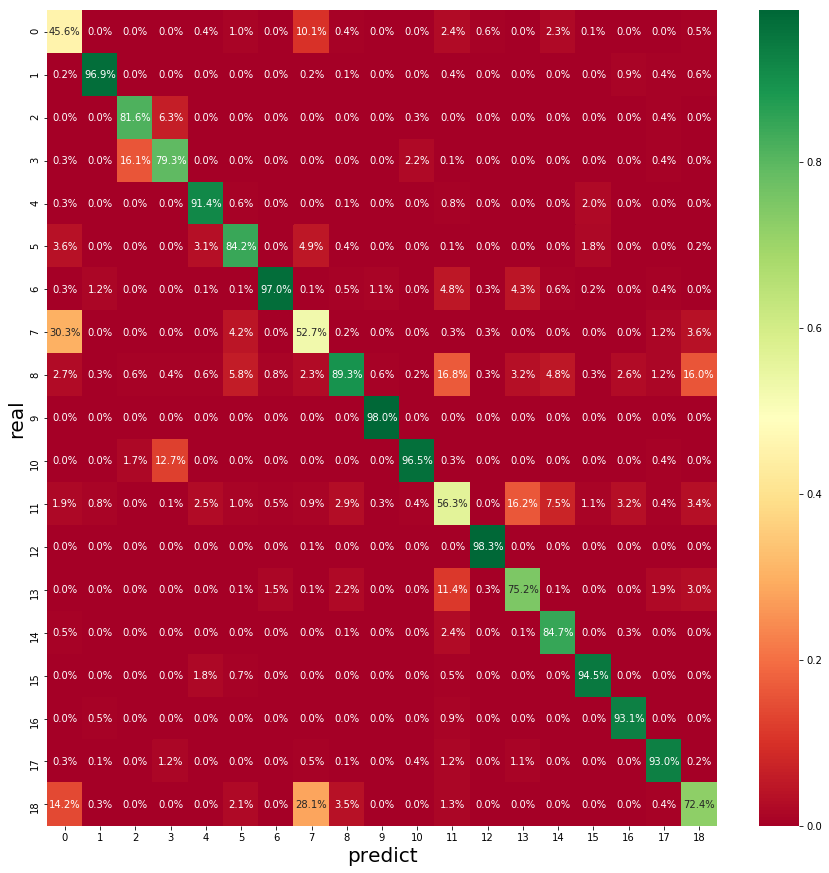

In [40]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [53]:
train_ds = lgb.Dataset(train_X, label = train_y)

In [54]:
lgmb_model = lgb.train(params, train_ds,num_boost_round= 2000, verbose_eval=100)

In [58]:
train_y_pred = lgmb_model.predict(train_X)

In [55]:
y_pred = lgmb_model.predict(test_X)

In [56]:
y_pred

array([[7.75352905e-08, 2.04337802e-09, 8.80555199e-08, ...,
        2.11017374e-11, 4.79872924e-06, 8.15108115e-07],
       [2.51551946e-07, 3.28640225e-09, 5.93130507e-12, ...,
        1.13039935e-12, 6.99342332e-08, 1.17483804e-05],
       [5.86530156e-07, 6.05323749e-07, 1.01369548e-10, ...,
        1.20643657e-13, 2.69449961e-07, 8.73648702e-07],
       ...,
       [1.03809095e-05, 3.89636624e-06, 1.35536943e-11, ...,
        5.64255703e-12, 4.28368326e-08, 6.57230913e-02],
       [3.67830715e-08, 8.38926875e-10, 2.31616043e-12, ...,
        5.50590290e-13, 1.73811230e-09, 2.54733375e-04],
       [8.42248612e-06, 5.04463750e-11, 3.21133107e-12, ...,
        6.64575761e-14, 2.91624900e-10, 5.19790721e-07]])

In [57]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)